# Assessment 2: CNNs for image classification

## Setup: import lib

In [1]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network 
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\cuda\memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


## Step01: Data exploration

In [3]:
## Download from cifar10
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Exploratory Image analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Check Shape of images:  torch.Size([3, 32, 32]) 4
Preview Images with Label : truck
Show of images unique labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


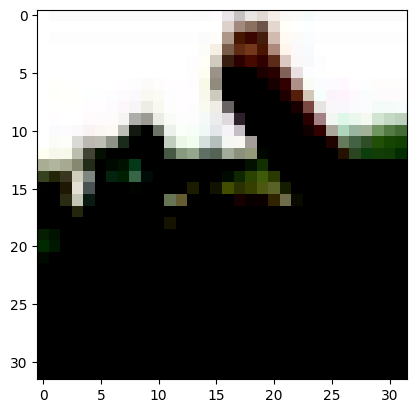

In [4]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [5]:
batch_size = 2
## apply the dataloader
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 32, 32])


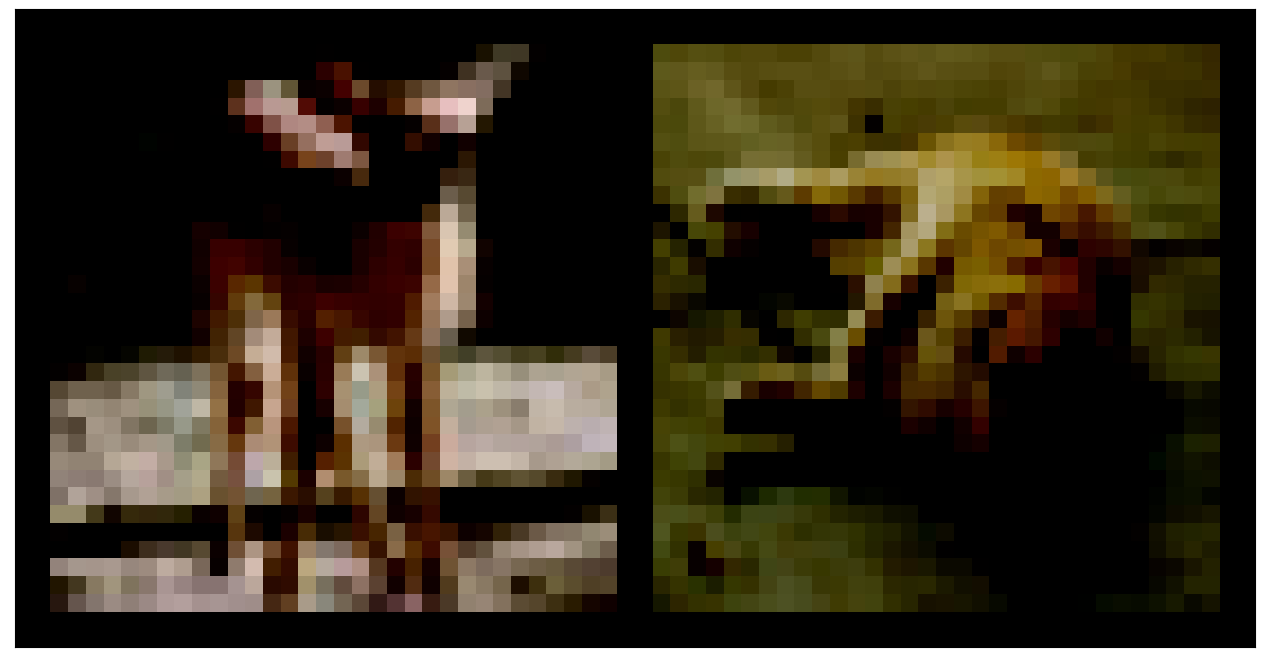

In [6]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [7]:
for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        break
print(labels)

tensor([7, 3], device='cuda:0')


In [8]:
len(labels)

2

In [9]:
def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs):
    # create set to collect the output
    train_loss=[]
    train_accuracy=[]
    test_accuracy=[]
    
    
    # get the inout and output

    for epoch in range(num_epochs):
        
        correct_train = 0
        total_train = 0
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
        
            #forward feed
            output_train = model(inputs)
            _, predicted = torch.max(output_train.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            #calculate the loss
            loss = criterion(output_train, labels)
            #backward propagation: calculate gradients
            loss.backward()
            #update the weights
            optimizer.step()
            
        # collect history data
        train_loss.append(loss.item())
        train_accuracy.append((100 * correct_train / total_train))

        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs_test = model(images)
                _, predicted = torch.max(outputs_test.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
            # print(output_test,y_test)
            test_accuracy.append((100 * correct_test / total_test))

        # if (epoch + 1) % 100 == 0:
            # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy[-1]:.2f}, Test Accuracy: {test_accuracy[-1]:.2f}")
            
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy[-1]:.2f}, Test Accuracy: {test_accuracy[-1]:.2f}")

    return train_loss, train_accuracy, test_accuracy

In [46]:
## adding the progress bar
import time
from tqdm import tqdm

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, device='cpu'):
    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)
        
        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(100 * epoch_acc)
        
        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)
                
        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(100 * correct_test.double() / total_test)
        
        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')
        
    return train_loss, train_accuracy, test_loss, test_accuracy


## Initialize network

### network: workshop CNN

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### network: ResNet18

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        # Load the pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=True)
        # Modify the final fully connected layer
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet18(x)

# Initialize the model and move it to GPU if available
resnet18 = ResNet18().to(device)
print(resnet18)

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [21]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18_2():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
    
test()
# Initialize the model and move it to GPU if available
resnet18_2 = ResNet18_2().to(device)
print(resnet18_2)

torch.Size([1, 10])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, m

### Train the network

In [49]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

Epoch 1/10 Testing: 100%|██████████| 5000/5000 [00:13<00:00, 361.76it/s]


Epoch 1/10, Train Loss: 0.9722, Train Acc: 66.60%, Test Loss: 1.3478, Test Acc: 58.21%, Time: 153.49s


Epoch 2/10 Testing: 100%|██████████| 5000/5000 [00:12<00:00, 407.04it/s]


Epoch 2/10, Train Loss: 0.9645, Train Acc: 66.58%, Test Loss: 1.4148, Test Acc: 56.99%, Time: 143.85s


Epoch 3/10 Testing: 100%|██████████| 5000/5000 [00:12<00:00, 397.62it/s]


Epoch 3/10, Train Loss: 0.9658, Train Acc: 66.98%, Test Loss: 1.3011, Test Acc: 59.72%, Time: 150.16s


Epoch 4/10 Testing: 100%|██████████| 5000/5000 [00:13<00:00, 361.77it/s]


Epoch 4/10, Train Loss: 0.9596, Train Acc: 67.26%, Test Loss: 1.3398, Test Acc: 57.04%, Time: 146.08s


Epoch 5/10 Testing: 100%|██████████| 5000/5000 [00:12<00:00, 385.98it/s]


Epoch 5/10, Train Loss: 0.9542, Train Acc: 67.55%, Test Loss: 1.3109, Test Acc: 59.21%, Time: 152.89s


Epoch 6/10 Testing: 100%|██████████| 5000/5000 [00:14<00:00, 341.47it/s]


Epoch 6/10, Train Loss: 0.9393, Train Acc: 68.12%, Test Loss: 1.3718, Test Acc: 57.70%, Time: 155.52s


Epoch 7/10 Testing: 100%|██████████| 5000/5000 [00:13<00:00, 374.26it/s]


Epoch 7/10, Train Loss: 0.9381, Train Acc: 68.13%, Test Loss: 1.3699, Test Acc: 59.35%, Time: 157.96s


Epoch 8/10 Testing: 100%|██████████| 5000/5000 [00:12<00:00, 398.98it/s]


Epoch 8/10, Train Loss: 0.9404, Train Acc: 68.26%, Test Loss: 1.3399, Test Acc: 58.26%, Time: 151.40s


Epoch 9/10 Testing: 100%|██████████| 5000/5000 [00:12<00:00, 400.16it/s]


Epoch 9/10, Train Loss: 0.9354, Train Acc: 68.39%, Test Loss: 1.3953, Test Acc: 58.49%, Time: 146.76s


Epoch 10/10 Testing: 100%|██████████| 5000/5000 [00:09<00:00, 518.69it/s]


Epoch 10/10, Train Loss: 0.9387, Train Acc: 68.67%, Test Loss: 1.4003, Test Acc: 59.06%, Time: 132.69s


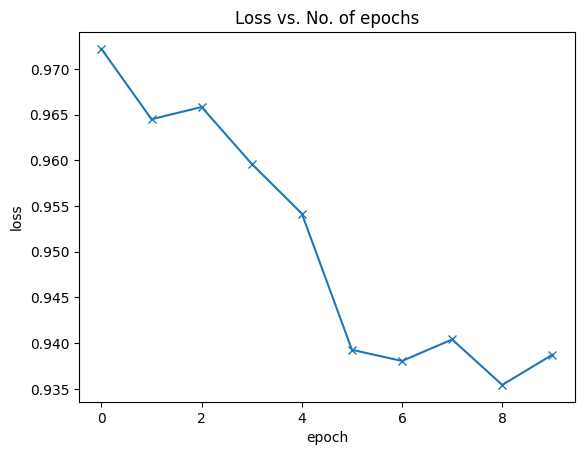

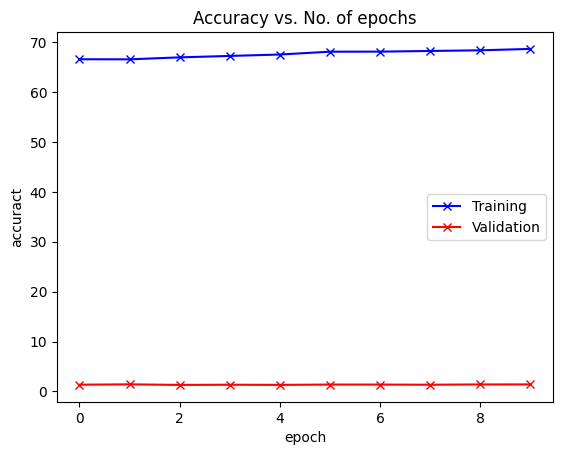

In [48]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
model = net
net_results = train_network(model, 
                            optimizer, 
                            criterion, 
                            trainloader, 
                            testloader, 
                            num_epochs
                            )

# plot the chart
plot_loss(net_results[0])
plot_acc(net_results[1], net_results[2])

# save the model info
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

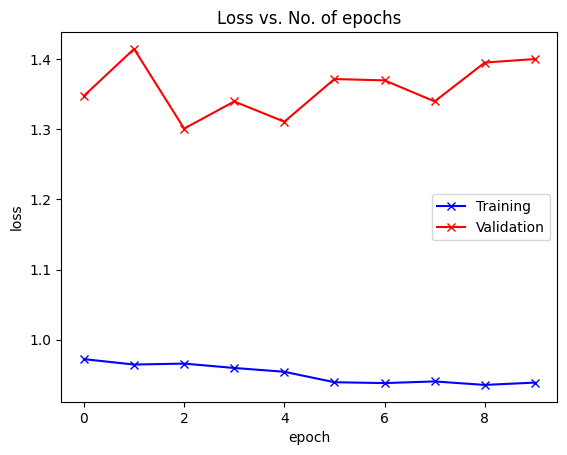

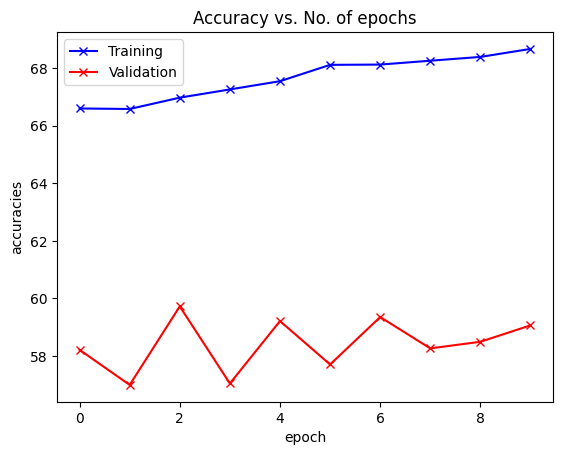

In [50]:
# plot the chart
plot_loss(net_results[0], net_results[2])
plot_acc(net_results[1], net_results[3])

Epoch 1/5, Train Loss: 0.3242, Train Accuracy: 38.30, Test Accuracy: 54.03
Epoch 2/5, Train Loss: 0.4348, Train Accuracy: 63.40, Test Accuracy: 69.97
Epoch 3/5, Train Loss: 1.3459, Train Accuracy: 74.55, Test Accuracy: 75.42
Epoch 4/5, Train Loss: 0.0755, Train Accuracy: 80.91, Test Accuracy: 77.41
Epoch 5/5, Train Loss: 0.0205, Train Accuracy: 85.39, Test Accuracy: 78.70


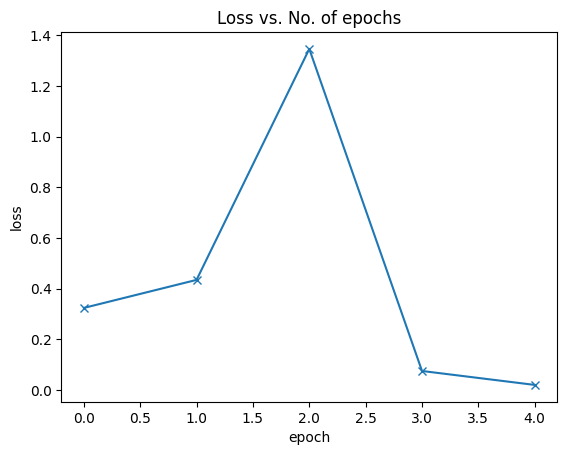

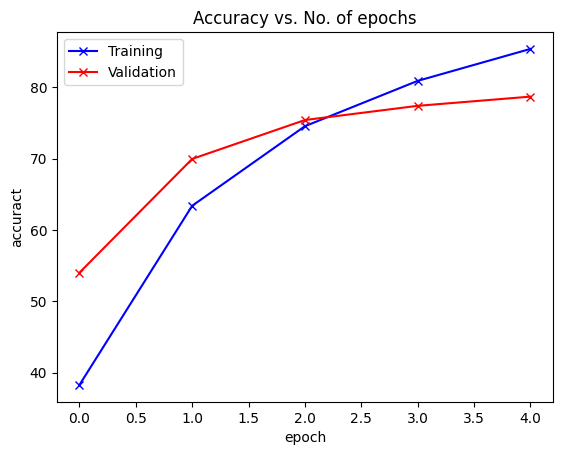

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_2.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
model = resnet18_2
resnet18_results = train_network(model, 
                            optimizer, 
                            criterion, 
                            trainloader, 
                            testloader, 
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0])
plot_acc(resnet18_results[1], resnet18_results[2])

# save the model info
PATH = './cifar_resnet18.pth'
torch.save(resnet18_2.state_dict(), PATH)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet121.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
model = densenet121
densenet121_results = train_network(model, 
                            optimizer, 
                            criterion, 
                            trainloader,  
                            testloader, 
                            num_epochs
                            )

# plot the chart
plot_loss(densenet121_results[0])
plot_acc(densenet121_results[1], densenet121_results[2])

# save the model info
PATH = './cifar_densenet121.pth'
torch.save(densenet121.state_dict(), PATH)

Epoch 1/10, Train Loss: 2.9159, Train Accuracy: 10.89, Test Accuracy: 11.38
Epoch 2/10, Train Loss: 2.2116, Train Accuracy: 11.16, Test Accuracy: 11.38
Epoch 3/10, Train Loss: 2.4054, Train Accuracy: 11.17, Test Accuracy: 11.38
Epoch 4/10, Train Loss: 2.5566, Train Accuracy: 11.09, Test Accuracy: 11.38
Epoch 5/10, Train Loss: 2.6850, Train Accuracy: 11.09, Test Accuracy: 11.38
Epoch 6/10, Train Loss: 2.1842, Train Accuracy: 11.22, Test Accuracy: 11.38
Epoch 7/10, Train Loss: 2.0682, Train Accuracy: 11.11, Test Accuracy: 11.38
Epoch 8/10, Train Loss: 2.2662, Train Accuracy: 10.88, Test Accuracy: 11.38
Epoch 9/10, Train Loss: 2.5953, Train Accuracy: 11.10, Test Accuracy: 11.38


KeyboardInterrupt: 

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet_b0.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10
model = efficientnet_b0
efficientnet_b0_results = train_network(model, 
                            optimizer, 
                            criterion, 
                            trainloader, 
                            testloader, 
                            num_epochs
                            )

# plot the chart
plot_loss(efficientnet_b0_results[0])
plot_acc(efficientnet_b0_results[1], efficientnet_b0_results[2])

# save the model info
PATH = './cifar_efficientnet_b0.pth'
torch.save(efficientnet_b0.state_dict(), PATH)

## Test the Model

### Testing data

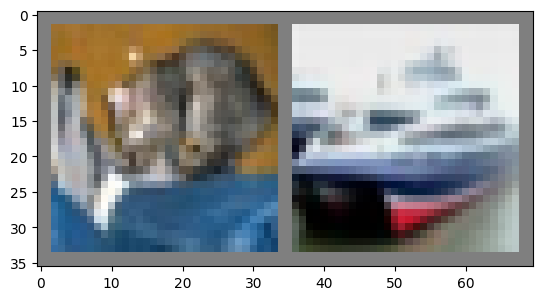

GroundTruth:    cat  ship


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [35]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))

resnet18_2 = ResNet18_2()
resnet18_2.load_state_dict(torch.load('./cifar_resnet18.pth'))

densenet121 = DenseNet121()
densenet121.load_state_dict(torch.load('./cifar_densenet121.pth'))

efficientnet_b0 = EfficientNetB0()
efficientnet_b0.load_state_dict(torch.load('./cifar_efficientnet_b0.pth'))

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [32]:
def test_set_acc(testloader, model):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
       
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [37]:
print('Model: net')
test_set_acc(testloader, net)

Model: net
Accuracy of the network on the 10000 test images: 59 %
Accuracy of airplane : 64 %
Accuracy of automobile : 70 %
Accuracy of  bird : 54 %
Accuracy of   cat : 50 %
Accuracy of  deer : 51 %
Accuracy of   dog : 41 %
Accuracy of  frog : 65 %
Accuracy of horse : 55 %
Accuracy of  ship : 75 %
Accuracy of truck : 62 %


In [45]:
print('Model: resnet18')
test_set_acc(testloader, resnet18)

Model: resnet18


KeyboardInterrupt: 

In [39]:
print('Model: densenet121')
test_set_acc(testloader, densenet121)

Model: densenet121
Accuracy of the network on the 10000 test images: 11 %
Accuracy of airplane :  1 %
Accuracy of automobile :  0 %
Accuracy of  bird :  1 %
Accuracy of   cat : 41 %
Accuracy of  deer : 13 %
Accuracy of   dog : 16 %
Accuracy of  frog :  1 %
Accuracy of horse :  0 %
Accuracy of  ship : 38 %
Accuracy of truck :  0 %


In [40]:
print('Model: efficientnet_b0')
test_set_acc(testloader, efficientnet_b0)

Model: efficientnet_b0
Accuracy of the network on the 10000 test images: 10 %
Accuracy of airplane : 12 %
Accuracy of automobile : 23 %
Accuracy of  bird : 14 %
Accuracy of   cat :  1 %
Accuracy of  deer :  8 %
Accuracy of   dog :  6 %
Accuracy of  frog : 16 %
Accuracy of horse :  2 %
Accuracy of  ship : 14 %
Accuracy of truck :  1 %
